### Setting the feelpp environment


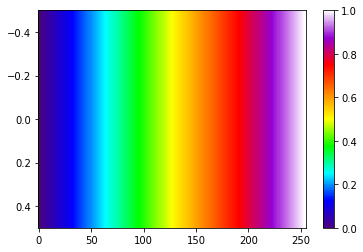

[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-18
 . feelpp_app files are stored in /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/logs


In [2]:
import sys
import feelpp
import feelpp.toolboxes.core as tb
from tools.Poisson import Poisson, runLaplacianPk, runConvergenceAnalysis, plot_convergence, custom_cmap

sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h

P = Poisson(dim = 2)



Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                            |
| | Environment                             

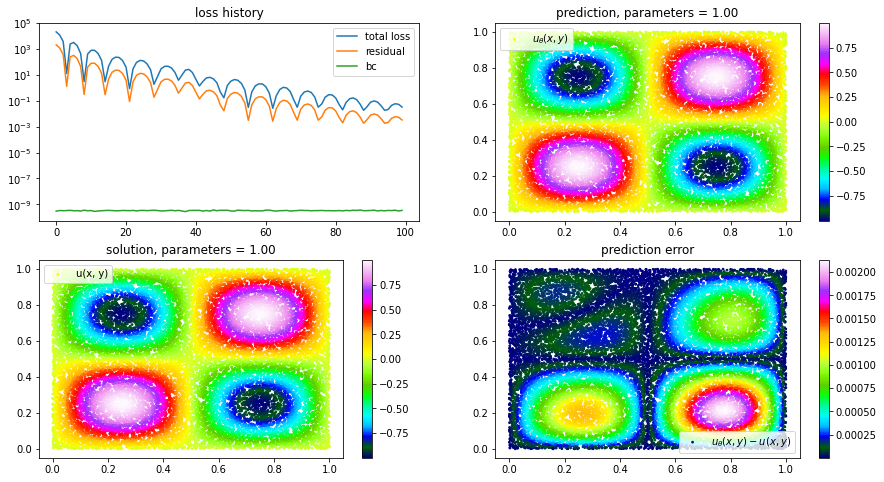

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 517

Nodes: [[0.82477343 0.04606718]
 [0.8300841  0.10191753]
 [0.7806651  0.09123866]
 ...
 [0.8390992  0.3016979 ]
 [0.8367227  0.1427201 ]
 [0.7476512  0.5844005 ]]

Feel++ solution 'cfpdes.poisson.u':
[-2.55882740e-01 -5.23014128e-01 -5.31600416e-01  4.51528639e-01
  5.54935336e-01  2.73693860e-01  0.00000000e+00  2.99670160e-01
  2.41641000e-01 -2.30834827e-01 -2.98673511e-01  0.00000000e+00
 -5.33562183e-01 -2.16567665e-01 -2.62957275e-01 -2.98950762e-01
 -1.16792865e-01 -1.96071774e-01  2.09492356e-01 -2.40673989e-01
 -5.17238796e-01 -2.29681395e-02 -1.59088224e-01 -2.30080426e-01
  1.77676231e-02  7.04201043e-01  4.76363331e-01  4.27088797e-01
 -3.99901003e-01  6.02511168e-01 -1.92533553e-01 -3.79127443e-01
  2.35925078e-01  1.21274188e-01  1.42786294e-01  3.49430382e-01
  1.98928967e-0

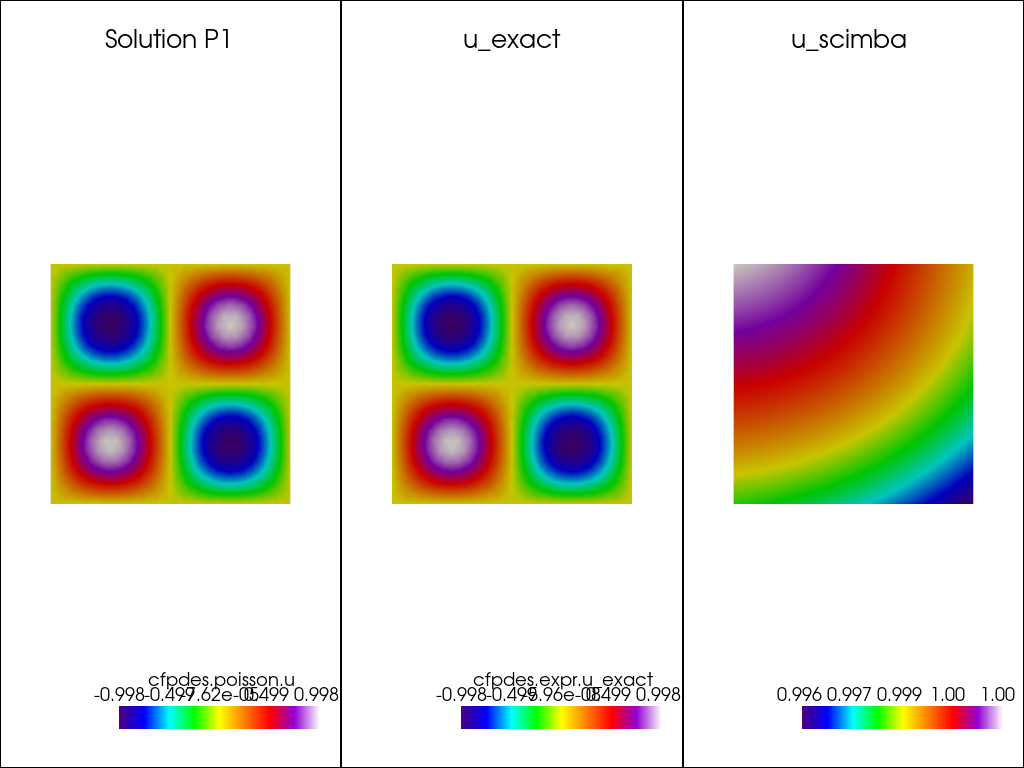

In [7]:
import torch
import numpy as np
import sympy as sp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tools.scimba_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain



u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
P(solver ='scimba', u_exact = u_exact)


In [ ]:

# Extract solution function u
u_scimba = P.scimba_solver()

# Define a grid of points
x_vals = np.linspace(0, 1, 50)
y_vals = np.linspace(0, 1, 50)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Convert to tensor and evaluate the neural network
coordinates_tensor = torch.tensor(grid_points, dtype=torch.double)
mu_value = 1
mu = torch.full((coordinates_tensor.size(0), 1), mu_value, dtype=torch.double)

with torch.no_grad():  # Ensure no gradient computations
    solution_tensor = u_scimba(coordinates_tensor, mu).numpy()

# Step 2: Perform symbolic regression using polynomial regression

# Prepare the polynomial features
poly = PolynomialFeatures(degree=3)  # Degree 3 for cubic polynomials
X_poly = poly.fit_transform(grid_points)

# Fit a linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, solution_tensor.ravel())

# Extract the polynomial coefficients
coefficients = model.coef_
intercept = model.intercept_

# Step 3: Convert the fitted polynomial to a symbolic expression

# Define symbolic variables
x, y = sp.symbols('x y')
poly_feature_names = poly.get_feature_names(input_features=['x', 'y'])

symbolic_expr = sp.sympify(intercept)
for coef, feature in zip(coefficients, poly_feature_names):
    if coef != 0:
        #coef = round(coef, 5)
        terms = feature.split()
        expr_terms = []
        for term in terms:
            if term == 'x':
                expr_terms.append(x)
            elif term == 'y':
                expr_terms.append(y)
            else:
                expr_terms.append(sp.symbols(term))
        symbolic_expr += coef * sp.Mul(*expr_terms)
print(symbolic_expr)
# Print the symbolic expression
expr_str = str(symbolic_expr)
expr_str = expr_str.replace('x^2', 'x*x')
expr_str = expr_str.replace('y^2', 'y*y')
expr_str = expr_str.replace('x^3', 'x*x*x')
expr_str = expr_str.replace('y^3', 'y*y*y')
expr_str = expr_str.replace('x^4', 'x*x*x*x')
expr_str = expr_str.replace('y^4', 'y*y*y*y')

print('u_scimba = ', expr_str)
P(g='0', solver ='scimba', u_exact =f"{expr_str}" )



### Examples with different parameters

In [ ]:

# for square domain

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

#P(rhs=rhs, g='0', solver='feelpp', u_exact = u_exact)
P(rhs=rhs, g='0', solver ='scimba', u_exact = u_exact)


In [ ]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
#P(rhs='5/2', g='y', solver='feelpp', u_exact = u_exact)
P(rhs='5/2', g='y', solver ='scimba', u_exact = u_exact)


In [ ]:

u_exact = '-y*y/2 - x*y*y*y/2 + y*y*y*y/4'
#P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', solver='feelpp', u_exact = u_exact)
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', solver ='scimba', u_exact = u_exact)

### Computing errors

In [ ]:
# Collect data to compute errors
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
grad_u_exact = '{2*pi*cos(2*pi*x) * sin(2*pi*y), 2*pi*sin(2*pi*x) * cos(2*pi*y)}'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []

for i in h:
  P(h=i, rhs=rhs, g='0', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)
"""
P(h=h[0], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)


# Plotting the error convergence rates
poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""

In [ ]:
# Collect data to compute errors
u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
grad_u_exact = '{1 - 2*x, (5 - 2*y)/4}'
rhs='5/2'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []

for i in h:
  P(h=i, rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)

"""
P(h=h[0], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)
"""

# Plotting the error convergence rates

poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()


In [ ]:
# Collect data to compute errors
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
grad_u_exact = '{-2*x*y*y + 6*x*y - 2*x*y*y*y + 6*x*y*y - 2*x*x*y*y + 6*x*x*y , -2*x*x*y + 6*x*x*y - 2*x*x*y*y + 6*x*x*y*y - 2*x*y*y + 6*x*y*y}'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []
for i in h:
  P(h=i, rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)
"""
P(h=h[0], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)
"""

# Plotting the error convergence rates

poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()

In [ ]:

"""
# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='feelpp', u_exact = u_exact)
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='scimba', u_exact = u_exact)

u_exact = 'x*x + y*y'
P(rhs='4', diff='{x,y,-y,x+y}', g='x*x + y*y',  solver='feelp', u_exact = u_exact)

poisson_json = lambda order,dim=2,name="u": P.model
print(poisson_json(dim=2,order=1))
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""
